In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#machine lerning
from sklearn.model_selection import train_test_split

In [73]:
data_train = pd.read_table('input/train_20171215.txt')
data_test_a = pd.read_table('input/test_A_20171225.txt')
data_test_b = pd.read_table('input/test_A_20171225.txt')

In [74]:
#  date  	  int   	  日期，经过脱敏，用数字来表示  
 # day_of_week  	  int  	  表示星期几  
#   brand  	  int  	  汽车品牌  
#   cnt  	  int  	  上牌数  
#过去 三年 上牌量
data_train.head()

,date,day_of_week,brand,cnt
0,1,3,1,20
1,1,3,5,48
2,2,4,1,16
3,2,4,3,20
4,3,5,1,1411


In [222]:
#helper function

def drop_brand( df ):
    cols = list(df.columns)
    if 'brand' in cols:
        df = df[["date",'day_of_week' ,"cnt"]].groupby(['date','day_of_week' ] , as_index =False).sum()
    return df
    
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
    
#test time stationary    
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    plt.figure(figsize=(20,10))
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [231]:
by_date_day=drop_brand(data_train)
# data_train[["date",'day_of_week' ,"cnt"]].groupby(['date','day_of_week' ] , as_index =False).sum()
by_date_day.head()
#list(data_train.columns)

,date,day_of_week,cnt
0,1,3,68
1,2,4,36
2,3,5,5565
3,4,6,4966
4,5,7,3346


In [229]:
by_brand=data_train[["brand" ,"cnt"]].groupby(['brand' ] , as_index =False).sum().sort_values(by='cnt', ascending=False)
by_brand.head()

,brand,cnt
4,5,408534
0,1,395603
1,2,389587
2,3,328680
3,4,294044


In [202]:
by_date=data_train[["date" ,"cnt"]].groupby(['date' ] , as_index =False).sum()

print(by_date.shape)
by_date.head()
# plt.figure(figsize=(20,10))
# plt.plot(by_date)

(1032, 2)


,date,cnt
0,1,68
1,2,36
2,3,5565
3,4,4966
4,5,3346


C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


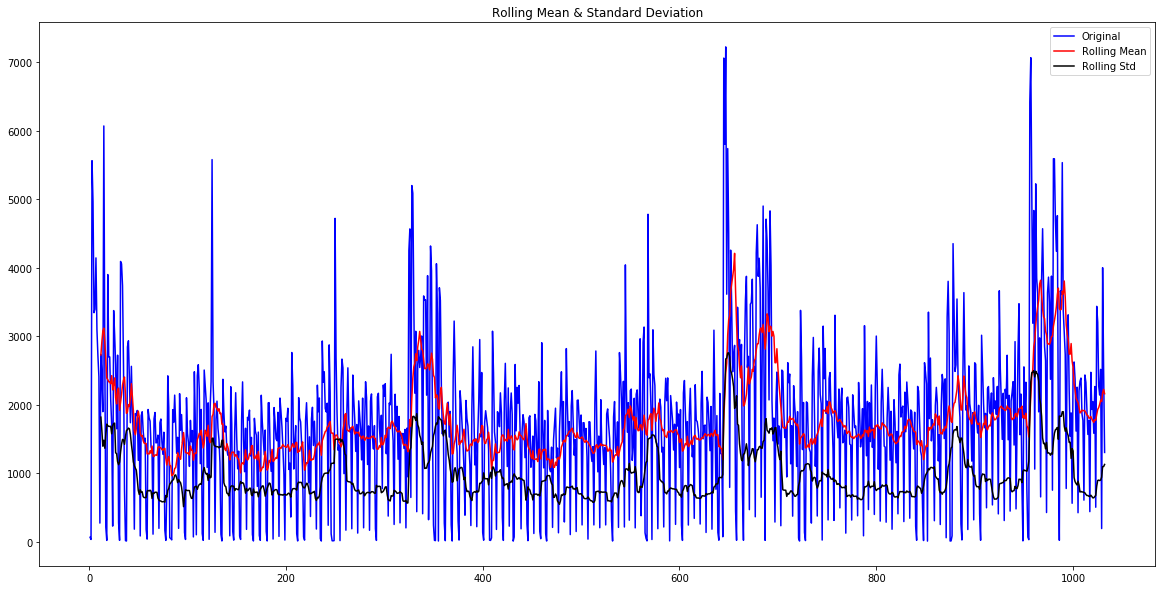

Results of Dickey-Fuller Test:
Test Statistic                   -4.906382
p-value                           0.000034
#Lags Used                       11.000000
Number of Observations Used    1020.000000
Critical Value (1%)              -3.436777
Critical Value (5%)              -2.864378
Critical Value (10%)             -2.568281
dtype: float64
[ 1.          0.2869884   0.0780555   0.03125833  0.09254919  0.08119867
  0.43709908  0.24885329  0.04551859 -0.00902343  0.04061353  0.11249685
  0.34135316  0.22074809  0.08731536  0.00181796  0.01532353  0.06854579
  0.26441149  0.20625644  0.09667736] [ 1.          0.28703107 -0.0043076   0.00917837  0.08843186  0.03357613
  0.44256843  0.02147026 -0.06166523 -0.00742792 -0.02170536  0.1224111
  0.17031906 -0.02546642  0.03686061 -0.01731739 -0.00987196  0.02842332
  0.06567313  0.01715831  0.01192802]


In [221]:
by_date2=data_train[["date" ,"cnt"]].groupby(['date' ] ).sum()
test_stationarity(by_date2["cnt"])

lag_acf = acf(by_date2["cnt"], nlags=20)
lag_pacf = pacf(by_date2["cnt"], nlags=20, method='ols')
print (lag_acf,lag_pacf)

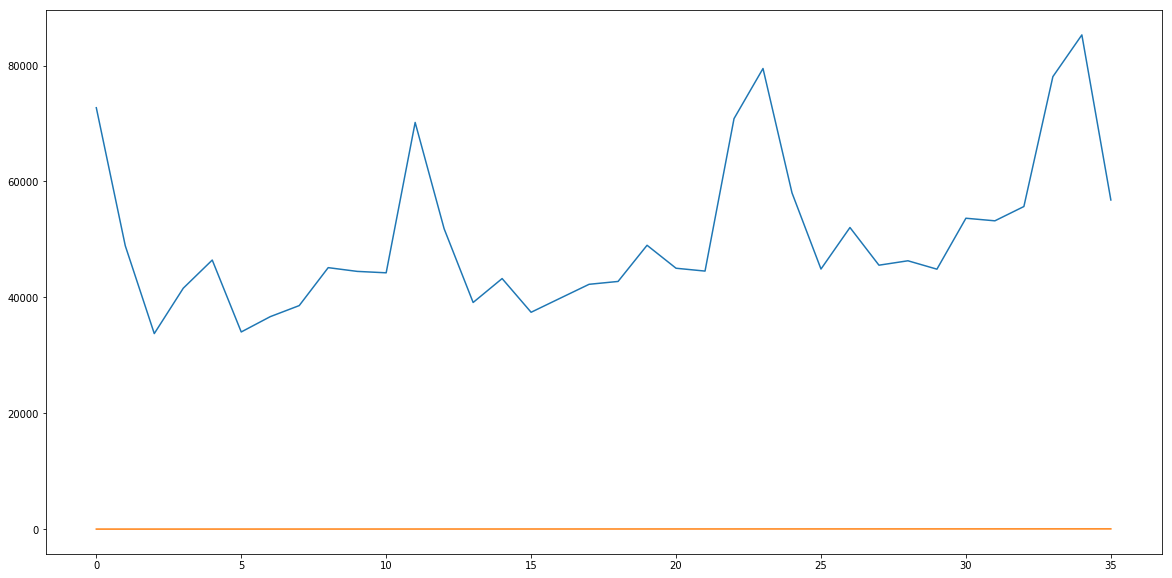

In [228]:
#按月plot 一下
by_date_by_month=by_date
by_date_by_month['month'] = pd.cut(by_date['date'] , 36)
by_date_by_month =by_date_by_month.drop(['date'],axis=1).groupby(['month' ] , as_index =False).sum()

month_range = by_date_by_month.month.values

for idx, val in enumerate(month_range):
     by_date_by_month.loc[ by_date_by_month['month'] == val, 'month2'] = idx
by_date_by_month = by_date_by_month.drop(['month'],axis=1)

#by_date_by_month.info()
plt.figure(figsize=(20,10))
plt.plot(by_date_by_month)

In [227]:
# test datetime
from datetime import datetime, timedelta
datetime(year=int(1),month=int(2),day=int(6))

datetime.datetime(1, 2, 6, 0, 0)